# 0716325 曾正豪

In [1]:
import json
import numpy as np
import tensorflow as tf
import statistics
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import callbacks
from tensorflow.keras import Model
import random

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay

## 1. Data Input & 3. Data Preprocessing
首先，我使用了json模組去讀取訓練集，接下來使用random模組裡面的shuffle去把訓練集的資料順序做打亂。

接下來，為了Data Visualization，我使用字典去記錄各種資料的分布狀況


In [2]:
with open("train.json") as f:
    train_set = json.load(f)
random.shuffle (train_set)

cnt = 0
ingredient_to_id = {}
ingredient_to_cnt = {}
ingredients = []

cuisine_cnt = 0
cuisine_to_id = {}
cuisine_to_cnt = {}
cuisines = []

valuecount_cnt = 0
valuecount_to_id = {}
valuecount_to_cnt = {}
valuecounts = []

for item in train_set:
    cuisine = item['cuisine']
    if cuisine not in cuisine_to_id:
        cuisine_to_id[cuisine] = cuisine_cnt
        cuisine_cnt += 1
        cuisine_to_cnt[cuisine] = 1
        cuisines.append(cuisine)
    else:
        cuisine_to_cnt[cuisine] += 1

    valuecount = len(item['ingredients'])
    valuecounts.append(valuecount)
    if valuecount not in valuecount_to_id:
        valuecount_to_id[valuecount] = valuecount_cnt
        valuecount_cnt += 1
        valuecount_to_cnt[valuecount] = 1
    else:
        valuecount_to_cnt[valuecount] += 1

    for ingredient in item['ingredients']:
        if ingredient not in ingredient_to_id:
            ingredient_to_id[ingredient] = cnt
            cnt += 1
            ingredient_to_cnt[ingredient] = 1
            ingredients.append(ingredient)
        else:
            ingredient_to_cnt[ingredient] += 1
        if len(ingredient.split()) > 1:
            for little in ingredient.split():
                if little not in ingredient_to_id:
                    ingredient_to_id[little] = cnt
                    cnt += 1
                    ingredient_to_cnt[little] = 1
                    ingredients.append(little)
                else:
                    ingredient_to_cnt[little] += 1


## 2. Data Visualization
### Plot the data distribution by value count of their labels (targets).
在這部分，我先將儲存出現次數的字典，依照出現次數將其排序並放入list中，並且使用pyplot的bar去繪製

[('italian', 5910), ('mexican', 4784), ('southern_us', 3279), ('indian', 2249), ('french', 2009), ('chinese', 1980), ('cajun_creole', 1159), ('thai', 1146), ('japanese', 1055), ('greek', 875), ('spanish', 748), ('moroccan', 630), ('vietnamese', 618), ('korean', 609), ('british', 586), ('filipino', 553), ('irish', 485), ('jamaican', 408), ('russian', 348), ('brazilian', 343)]


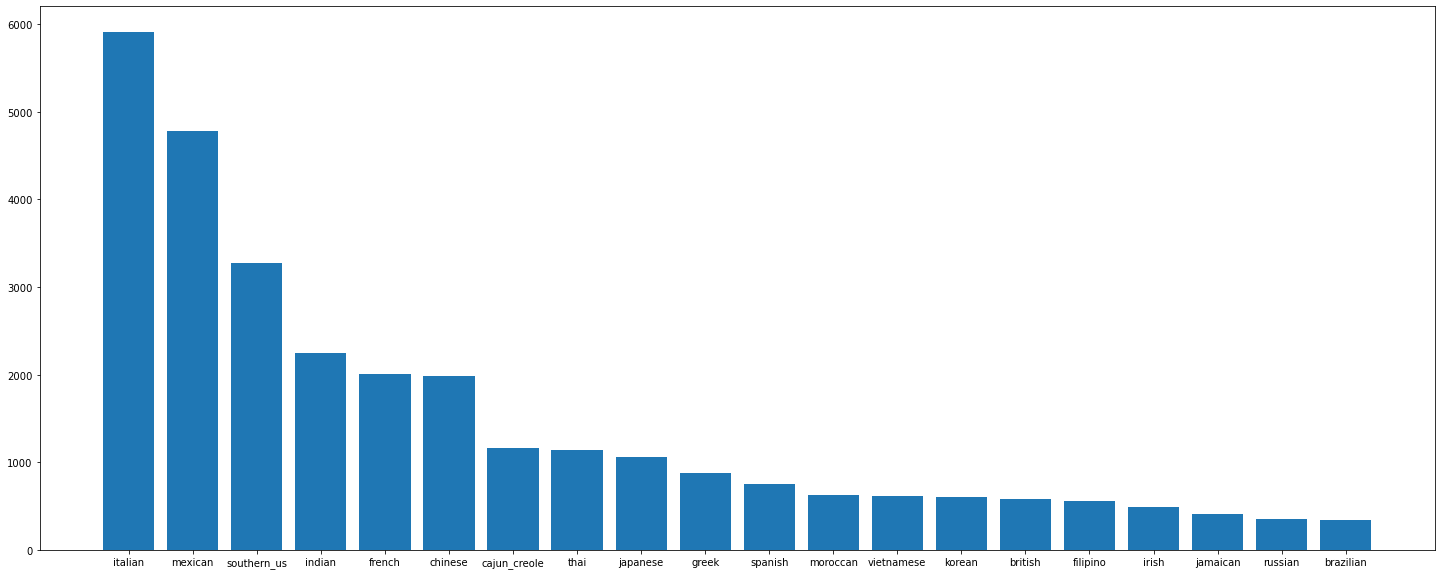

In [3]:
temp = sorted(cuisine_to_cnt.items(), key=lambda item: item[1])
temp.reverse()
print(temp)

x_list = []
y_list = []
for i in temp:
    x_list.append(i[0])
    y_list.append(i[1])
plt.figure(figsize=(25,10))
plt.bar(x_list, y_list)
plt.show()

### Plot the data distribution by value count of top 30 features.
在這部分，我先將儲存出現次數的字典，依照出現次數將其排序並放入list中，並且使用pyplot的bar去繪製

[('pepper', 19165), ('salt', 18324), ('oil', 17424), ('garlic', 14152), ('ground', 13638), ('fresh', 13468), ('sauce', 9558), ('sugar', 9324), ('onions', 9266), ('cheese', 8695), ('chicken', 8519), ('olive', 8239), ('black', 7928), ('water', 7329), ('red', 6837), ('flour', 6592), ('butter', 6472), ('green', 6444), ('tomatoes', 6441), ('powder', 6141), ('olive oil', 6000), ('chopped', 5945), ('cloves', 5625), ('juice', 5397), ('onion', 5192), ('white', 5180), ('eggs', 4870), ('garlic cloves', 4644), ('rice', 4525), ('cream', 4488)]


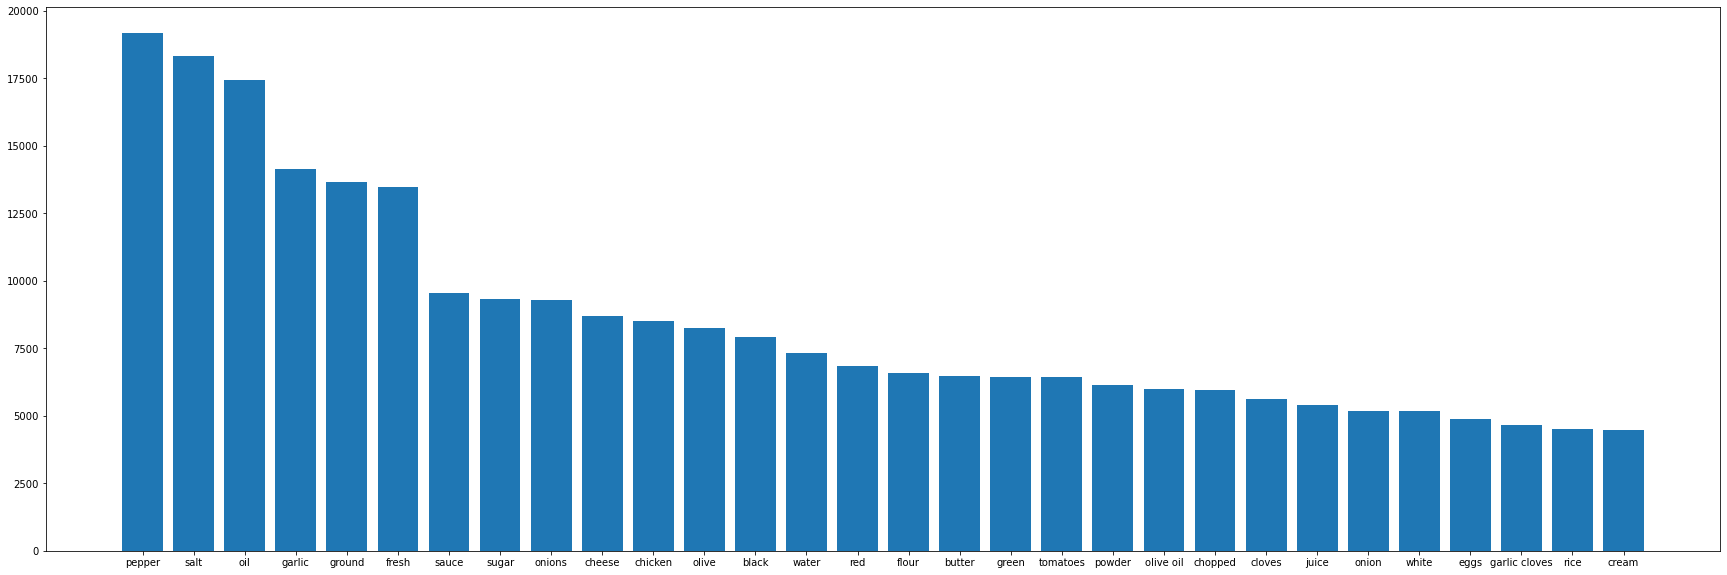

In [4]:
temp = sorted(ingredient_to_cnt.items(), key=lambda item: item[1])
temp.reverse()
temp = temp[:30]
print(temp)

x_list = []
y_list = []
for i in temp:
    x_list.append(i[0])
    y_list.append(i[1])
plt.figure(figsize=(30,10))
plt.bar(x_list, y_list)
plt.show()

### Plot the data distribution by value count of the number of ingredients.
在這部分，我先將儲存出現次數的字典，依照出現次數將其排序並放入list中，並且使用pyplot的bar去繪製

[(9, 2796), (10, 2763), (8, 2673), (11, 2606), (7, 2533), (12, 2352), (13, 2045), (6, 1971), (14, 1704), (5, 1424), (15, 1316), (16, 1093), (17, 891), (4, 826), (18, 639), (19, 465), (3, 406), (20, 363), (21, 244), (22, 169), (2, 137), (23, 98), (24, 67), (25, 56), (26, 33), (28, 22), (1, 17), (29, 13), (30, 11), (31, 10), (27, 10), (33, 4), (35, 3), (32, 2), (34, 2), (36, 2), (40, 2), (49, 2), (43, 1), (59, 1), (65, 1), (52, 1)]


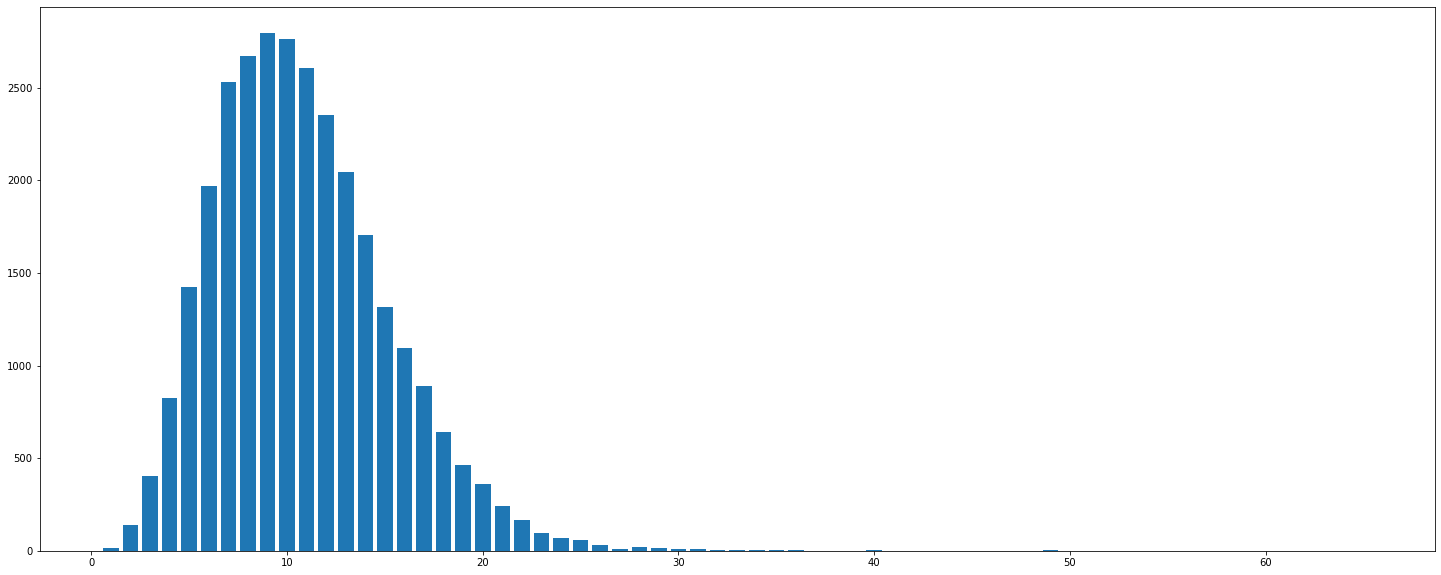

In [5]:
temp = sorted(valuecount_to_cnt.items(), key=lambda item: item[1])
temp.reverse()
print(temp)

x_list = []
y_list = []
for i in temp:
    x_list.append(i[0])
    y_list.append(i[1])
plt.figure(figsize=(25,10))
plt.bar(x_list, y_list)
plt.show()

## 3. Data Preprocessing
在這部分，

In [6]:
mean = statistics.mean(valuecounts)
stdev = statistics.stdev(valuecounts)
print(mean)
print(stdev)
x = np.zeros((len(train_set), cnt+1), np.float)
y = np.zeros((len(train_set), cuisine_cnt), np.float)
for id, item in enumerate(train_set):
    for ingredient in item['ingredients']:
        x[id][ ingredient_to_id[ingredient] + 1 ] = 1.0
        for little in ingredient.split():
            x[id][ ingredient_to_id[little] + 1 ] = 1.0
    x[id][0] = (valuecounts[id] - mean) / stdev
    y[id][ cuisine_to_id[item['cuisine']] ] = 1.0


10.770269362531067
4.4239170766871725


## 4. Artificial Neural Networks & 5. Validation Method
這邊我使用了2層隱藏層的神經網路進行實作，並且愈往後面層的神經元數量會愈少，形成一種金字塔型結構，同時在最後一層我使用了softmax作為激活函數，以作為各種分類的機率分布

接著，我將整個訓練集的前70%作為訓練集，後30%做為測試集，由於我已經在前面做了shuffle了，因此這邊直接切在70%就相當於做了Holdout validation with the ratio 7:3。

在訓練的過程中，我設定了兩個回調函數，分別是EarlyStopping用來避免overfitting以及ReduceLROnPlateau用來適時減少學習率
我的loss function是使用Crossentropy，並且搭配adam optimizer進行backpropogation

In [13]:
size_list = [256, 64]
model = tf.keras.Sequential()
for i in size_list:
    model.add(layers.Dense(i))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())
    model.add(layers.Dropout(0.5))
model.add(layers.Dense(20, activation='softmax'))

train_size = int(len(train_set) * 0.7)
x_train = x[:train_size]
y_train = y[:train_size]
x_test = x[train_size:]
y_test = y[train_size:]

print(x.shape)
print(y.shape)
print(x_train.shape)
print(y_train.shape)
my_callbacks = [
    callbacks.EarlyStopping(patience=50, monitor = 'val_accuracy', restore_best_weights=True),
    callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=0, cooldown=3, min_lr=0.00001)
]

model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])
history =  model.fit(x_train, y_train, batch_size=32, epochs=500, validation_data=(x_test, y_test), callbacks=my_callbacks)
model.summary()


(29774, 8460)
(29774, 20)
(20841, 8460)
(20841, 20)
Epoch 1/500
163/163 [==============================] - 2s 9ms/step - loss: 3.0349 - accuracy: 0.1585 - val_loss: 2.6865 - val_accuracy: 0.4292
Epoch 2/500
163/163 [==============================] - 1s 7ms/step - loss: 2.1560 - accuracy: 0.3930 - val_loss: 2.1744 - val_accuracy: 0.5936
Epoch 3/500
163/163 [==============================] - 1s 7ms/step - loss: 1.8174 - accuracy: 0.4977 - val_loss: 1.6173 - val_accuracy: 0.6493
Epoch 4/500
163/163 [==============================] - 1s 7ms/step - loss: 1.6123 - accuracy: 0.5597 - val_loss: 1.3396 - val_accuracy: 0.6764
Epoch 5/500
163/163 [==============================] - 1s 7ms/step - loss: 1.4930 - accuracy: 0.5927 - val_loss: 1.2167 - val_accuracy: 0.6948
Epoch 6/500
163/163 [==============================] - 1s 7ms/step - loss: 1.3785 - accuracy: 0.6294 - val_loss: 1.1359 - val_accuracy: 0.7088
Epoch 7/500
163/163 [==============================] - 1s 7ms/step - loss: 1.2958 - accura

## 6. Results
將測試集餵入神經網路，並使用argmax獲得分類，並使用sklearn套件繪製出Confusion matrix以及report

<Figure size 1080x1080 with 0 Axes>

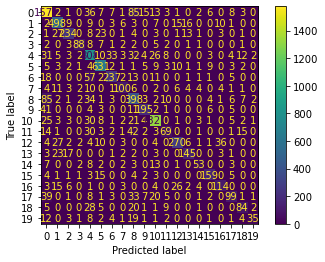

              precision    recall  f1-score   support

           0       0.84      0.89      0.86      1765
           1       0.81      0.86      0.83       579
           2       0.81      0.73      0.77       320
           3       0.87      0.72      0.79       123
           4       0.74      0.82      0.78       986
           5       0.86      0.91      0.89       693
           6       0.80      0.68      0.73       348
           7       0.77      0.63      0.69       159
           8       0.57      0.71      0.63       561
           9       0.82      0.73      0.77       268
          10       0.91      0.92      0.92      1435
          11       0.62      0.38      0.47       184
          12       0.82      0.73      0.77       370
          13       0.77      0.72      0.75       200
          14       0.72      0.56      0.63        94
          15       0.82      0.80      0.81       198
          16       0.67      0.64      0.65       178
          17       0.67    

In [14]:
y_pred = model(x_test)
y_pred = tf.argmax(y_pred, axis=1)
y_test = tf.argmax(y_test, axis=1)
plt.figure(figsize=(15,15))
CM = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred)
ConfusionMatrixDisplay(confusion_matrix=CM).plot()
plt.show()
print(report)

## 7.Comparison & Conclusion
在調整神經網路超參數的過程中，我有試過其他不同大小的神經網路

## 8.Kaggle Submission 

In [18]:
my_callbacks = [
    callbacks.EarlyStopping(patience=50, monitor = 'accuracy', restore_best_weights=True),
    callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=3, verbose=0, cooldown=3, min_lr=0.00001)
]

model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.00005),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])
history =  model.fit(x, y, batch_size=32, epochs=500, callbacks=my_callbacks)
model.summary()


with open("test.json") as f:
    test_set = json.load(f)

id_list = []
x_data = np.zeros((len(test_set), cnt+1), np.float)
for id, item in enumerate(test_set):
    id_list.append(item['id'])
    for ingredient in item['ingredients']:
        for little in ingredient.split():
            if little in ingredient_to_id:
                x_data[id][ ingredient_to_id[little] + 1 ] = 1.0
        if ingredient in ingredient_to_id:
            x_data[id][ ingredient_to_id[ingredient] + 1 ] = 1.0
        else:
            #print(ingredient)
            pass
        x_data[id][0] = (len(item['ingredients']) - mean) / stdev
        
            
y_data = model(x_data)
index = tf.argmax(y_data, axis=1)
with open("submission.csv", "w") as submission:
    submission.write("id,Category\n")
    for i in range(len(id_list)):
        submission.write(str(id_list[i])+","+cuisines[index[i]]+"\n")

Epoch 1/500
931/931 [==============================] - 6s 6ms/step - loss: 0.2151 - accuracy: 0.9365
Epoch 2/500
931/931 [==============================] - 5s 6ms/step - loss: 0.2098 - accuracy: 0.9355
Epoch 3/500
931/931 [==============================] - 6s 6ms/step - loss: 0.2081 - accuracy: 0.9356
Epoch 4/500
931/931 [==============================] - 5s 6ms/step - loss: 0.2068 - accuracy: 0.9361
Epoch 5/500
931/931 [==============================] - 5s 6ms/step - loss: 0.2134 - accuracy: 0.9346
Epoch 6/500
931/931 [==============================] - 5s 6ms/step - loss: 0.2099 - accuracy: 0.9366
Epoch 7/500
931/931 [==============================] - 5s 6ms/step - loss: 0.1976 - accuracy: 0.9379
Epoch 8/500
931/931 [==============================] - 5s 6ms/step - loss: 0.2187 - accuracy: 0.9331
Epoch 9/500
931/931 [==============================] - 5s 6ms/step - loss: 0.1921 - accuracy: 0.9397
Epoch 10/500
931/931 [==============================] - 5s 6ms/step - loss: 0.2202 - accura